## 0. Import packages

In [1]:
import pandas as pd
import gzip
import math
from tqdm import tqdm
from itertools import chain, combinations
from Association import Association
from math import sqrt
tqdm.pandas() #for progres_apply etc.

## 1. Load data from previous step

In [2]:
seed_index = 0

In [3]:
import pickle
train_df = pickle.load(open(f"pickle_dumps/train_df_{seed_index}.p", "rb"))
tests_df = pickle.load(open(f"pickle_dumps/test_df_{seed_index}.p", "rb"))

article_train_df = pickle.load(open(f"pickle_dumps/article_train_df_{seed_index}.p", "rb"))
article_test_df = pickle.load(open(f"pickle_dumps/article_test_df_{seed_index}.p", "rb"))

In [4]:
train_df

,item_id,user_id
0,"[3485, 2370, 163, 2188, 2484, 2130, 3197, 413,...",0
1,"[470, 3223, 1912, 4349, 2249, 380, 3860, 1483,...",1
2,"[173, 139, 2088, 2132, 285, 352, 678, 521, 798...",2
3,"[206, 299, 354, 1125, 2196, 2839, 1752, 1410, ...",3
4,"[417, 1897, 4786, 840, 1637, 3957, 926, 505, 4...",4
...,...,...
62965,[0],62965
62966,[80],62966
62967,[23],62967
62968,[11],62968


If we plot a disrtibution of the length per user, we see that most data leans towards a length of 100 items

34.22210576464983


(array([2.4862e+04, 1.4450e+04, 8.5030e+03, 5.1300e+03, 3.2860e+03,
        1.9140e+03, 1.1610e+03, 8.5600e+02, 6.1300e+02, 4.4600e+02,
        3.4300e+02, 2.5200e+02, 2.2000e+02, 1.6400e+02, 1.0200e+02,
        9.5000e+01, 7.8000e+01, 6.0000e+01, 5.3000e+01, 3.9000e+01,
        4.9000e+01, 4.7000e+01, 2.1000e+01, 2.6000e+01, 1.2000e+01,
        2.8000e+01, 1.7000e+01, 1.3000e+01, 6.0000e+00, 1.7000e+01,
        1.2000e+01, 1.0000e+01, 1.4000e+01, 7.0000e+00, 9.0000e+00,
        6.0000e+00, 3.0000e+00, 2.0000e+00, 6.0000e+00, 5.0000e+00,
        2.0000e+00, 2.0000e+00, 6.0000e+00, 8.0000e+00, 3.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([  1.  ,  15.24,  29.48,  43.72,  57.96,  72.2 ,  86.44, 100.68,
        114.92, 129.16, 143.4 , 157.64, 171.88, 186.12, 200.36, 214.6 ,
        228.84, 243.08, 257.32, 271.56, 285.8 , 300.04, 314.28, 328.52,
        342.76, 357.  , 371.24, 385.48, 399.72, 413.96, 428.2 , 442.44,
        456.68, 470.92, 485.16

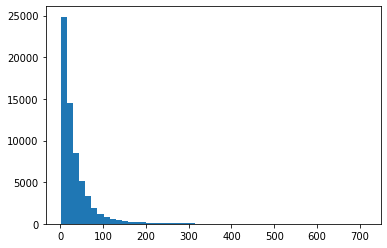

In [5]:
import matplotlib.pyplot as plt
x = [len(i) for i in train_df["item_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [6]:
article_train_df

,item_id,user_id
0,3485,"[0, 1, 4, 8, 10, 11, 43, 54, 58, 70, 133, 176,..."
1,2370,"[0, 2, 4, 5, 9, 16, 31, 67, 71, 78, 128, 145, ..."
2,163,"[0, 2, 4, 5, 8, 9, 11, 16, 17, 18, 19, 22, 23,..."
3,2188,"[0, 3, 4, 6, 8, 11, 13, 21, 25, 35, 39, 49, 52..."
4,2484,"[0, 11, 13, 25, 54, 74, 86, 89, 119, 120, 133,..."
...,...,...
7116,6696,[50173]
7117,7162,[50334]
7118,6679,[51212]
7119,5683,[52319]


The transposed dataframe that is used for building user association rules has only a few items most of the time. this is not that important because of the way user associations are build.

302.62126105884005


(array([6.41e+03, 3.17e+02, 1.30e+02, 7.40e+01, 4.20e+01, 2.60e+01,
        1.40e+01, 1.50e+01, 1.40e+01, 1.30e+01, 1.10e+01, 1.10e+01,
        6.00e+00, 3.00e+00, 2.00e+00, 4.00e+00, 2.00e+00, 2.00e+00,
        6.00e+00, 2.00e+00, 0.00e+00, 3.00e+00, 1.00e+00, 2.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 2.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 2.00e+00]),
 array([1.00000e+00, 5.78100e+02, 1.15520e+03, 1.73230e+03, 2.30940e+03,
        2.88650e+03, 3.46360e+03, 4.04070e+03, 4.61780e+03, 5.19490e+03,
        5.77200e+03, 6.34910e+03, 6.92620e+03, 7.50330e+03, 8.08040e+03,
        8.65750e+03, 9.23460e+03, 9.81170e+03, 1.03888e+04, 1.09659e+04,
        1.15430e+04, 1.21201e+04, 1.26972e+04, 1.32743e+04, 1.38514e+04,
        1.44285e+04, 1.50056e+04, 1.55827e+04, 1.61598e+04, 1

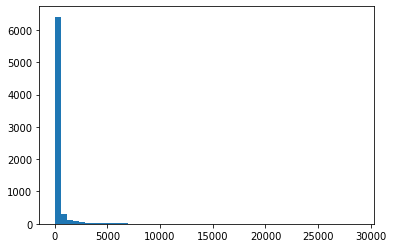

In [7]:
x = [len(i) for i in article_train_df["user_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [8]:
tests_df

,item_id,user_id
0,"[2955, 457, 1430, 2348, 1716, 102, 464, 2417, ...",0
1,"[56, 2486, 573, 1662, 3174, 3132, 292, 4443, 1...",1
2,"[3994, 187, 2602, 4571, 1231, 1620, 1182, 926,...",2
3,"[840, 596, 1148, 890, 815, 1096, 3442, 1660, 8...",3
4,"[980, 1094, 2780, 1095, 3803, 2973, 2052, 981,...",4
...,...,...
62965,[3],62965
62966,[19],62966
62967,[79],62967
62968,[5],62968


In [9]:
data = train_df.set_index("user_id").to_dict()["item_id"]
article_data = article_train_df.set_index("item_id").to_dict()["user_id"]

test_users = tests_df["user_id"].tolist()

## 2. Functions or building association rules

In [10]:
# def eclat(prefix, minsup, items, start=True):
#     """
#     Basic eclat implementation for finding frequent itemsets
#     """
#     frequents = []
#     while items:
#         i,itids = items.pop()
#         isupp = len(itids)
#         if isupp >= minsup:
#             frequents.append((frozenset(prefix + [i]), isupp))
#             suffix = [] 
#             for j, ojtids in items:
#                 jtids = set(itids) & set(ojtids)
#                 if len(jtids) >= minsup:
#                     suffix.append((j,jtids))
#             frequents.extend(eclat(prefix+[i], minsup, sorted(suffix, key=lambda item: len(item[1]), reverse=True), False))
#     return frequents

In [11]:
# def subsets(itemset, include_empty_set=False):
#     """ List all strict subsets of an itemset without the empty set or with the empty set if include_empty_set=True
#         subsets({1,2,3}) --> [{1}, {2}, {3}, {1, 2}, {1, 3}, {2, 3}]
#     """
#     s = list(itemset)
#     if include_empty_set:
#         return map(set, chain.from_iterable(combinations(s, r) for r in range(0, len(s) + 1)))
#     return map(set, chain.from_iterable(combinations(s, r) for r in range(1, len(s))))

In [12]:
# def deriveRules(itemsets, minconf, test_users):
#     """ Returns all rules with conf >= minconf that can be derived from the itemsets.
#         Return: list of association rules in the format: [(antecedent, consequent, supp, conf), ...]
#     """
#     search_items = dict(itemsets)
#     rules = []
#     for item_set, supp in tqdm(itemsets):
#         if len(item_set) > 1: # itemsets with one frequent item are unable to generate a rule
#             for subset in subsets(item_set):  # for each subset generate a rule
#                 antecedent = frozenset(subset)
#                 consequent = item_set - subset
#                 if len(consequent)== 1: # only keep rules with one item in the consequent
#                     conf = supp / search_items[antecedent]
#                     if conf >= minconf: # assure confidence of the rule is high enough
#                         # if test_users are passed, only generate rules with one of the test users in the consequent
#                         if test_users:
#                             if list(consequent)[0] in test_users:
#                                 rules.append(Association(antecedent, consequent, conf, supp))
#                         else:
#                             rules.append(Association(antecedent, consequent, conf, supp))
                        

#     return rules

In [13]:
def convertTo(df):
    with open("eclat_in.txt", "w") as f:
        tmp = df.items()
        for item in tmp:
            s = ' '.join([str(elem) for elem in item[1]])
            f.write(s + "\n")
            

def convertFrom():
    res = []
    with open("eclat_out.txt", "r") as f:
        for line in f:
            try:
                tmp = line.strip()
                tmp = tmp.split(" <- ")
                consequent = [tmp[0]]
                tmp = tmp[1].split(" (")
                antecedent = tmp[0].split(" ")
                tmp = tmp[1].strip(')').split(", ")
                sup = tmp[0]
                conf = tmp[1]
                lift = tmp[2]
                z = tmp[3]
                antecedent = list(map(int, antecedent))
                consequent = list(map(int, consequent))
                res.append(Association(antecedent, consequent, float(conf), float(sup), 
                                       float(lift), float(z)))
            except:
                pass
    
    return res

In [14]:
convertTo(data)
!./eclat -tr -Z -s-1000 -c70 -el -ez -v" (%i, %a, %l, %e)" eclat_in.txt eclat_out.txt
for i in convertFrom():
    print(i)

./eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7121 item(s), 62970 transaction(s)] done [0.08s].
filtering, sorting and recoding items ... [613 item(s)] done [0.01s].
sorting and reducing transactions ... [60281/62970 transaction(s)] done [0.03s].
finding frequent item sets ... done [0.83s].
writing eclat_out.txt ... [978 rule(s)] done [0.00s].
all: 978
  0: 0
  1: 0
  2: 5
  3: 126
  4: 624
  5: 215
  6: 8
Conf: 1065.00	Supp: 4.00	Lift: 3.28257Z: 0.61891
	 {15, 7, 5} => {12}
Conf: 908.00	Supp: 4.00	Lift: 3.30237Z: 0.62428
	 {15, 9, 7} => {12}
Conf: 903.00	Supp: 5.00	Lift: 3.28419Z: 0.61935
	 {15, 10, 7, 0} => {12}
Conf: 714.00	Supp: 5.00	Lift: 3.30758Z: 0.62569
	 {19, 15, 7, 0} => {12}
Conf: 707.00	Supp: 5.00	Lift: 3.28164Z: 0.61866
	 {19, 15, 7, 1} => {12}
Conf: 1101.00	Supp: 4.00	Lift: 3.28343Z: 0.61914
	 {19, 15, 7} => {12}
Conf: 710.00	Supp: 4.00	Lift: 3.28905Z: 0.62067
	 {18, 

In [15]:
def genRules(min_conf, minsup, df):
    print("---writing data---")
    convertTo(df)
    print("---building rules---")
    !./eclat -tr -Z -s-$minsup -c$min_conf -el -v" (%i, %a, %l, %e)" eclat_in.txt eclat_out.txt
    print("---reading data---")
    rules = convertFrom()
    return rules

## 3. Build association rules

### Article association rules
Build rules of the form:
`Item1 and Item2 -> Item3`

In [16]:
%%time

print(len(data))

# Build the article association rules with a minimum support of 50 and minimum confidence of 0.85
raw_article_assos_rules = []
values = [(0,2000), (80,100), (50,333), (25,500)]
for conf,sup in values:
    tmp = genRules(conf, sup, data)
    tmp = sorted(tmp, key=lambda x: x.s * x.c, reverse=True)[:1000000]
    print(len(tmp))
    raw_article_assos_rules.extend(tmp)
    print(len(raw_article_assos_rules))

62970
---writing data---
---building rules---
./eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7121 item(s), 62970 transaction(s)] done [0.08s].
filtering, sorting and recoding items ... [7121 item(s)] done [0.00s].
sorting and reducing transactions ... [60790/62970 transaction(s)] done [0.04s].
finding frequent item sets ... done [6.66s].
writing eclat_out.txt ... [16327202 rule(s)] done [3.09s].
all: 16327202
  0: 0
  1: 7121
  2: 1234034
  3: 7758026
  4: 6351744
  5: 976277
---reading data---
1000000
1000000
---writing data---
---building rules---
./eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7121 item(s), 62970 transaction(s)] done [0.08s].
filtering, sorting and recoding items ... [2294 item(s)] done [0.00s].
sorting and reducing transactions ... [60752/62970 transaction(s)]

In [17]:
len(raw_article_assos_rules)

3189722

In [31]:
article_assos_rules = sorted(raw_article_assos_rules, key=lambda x: x.z, reverse=True)[:1000000]

In [32]:
%%time

# print number of rules with item 3 in the lhs
counter = 0
for r in article_assos_rules:
    if 3 in r.left:
        counter += 1
counter

CPU times: user 580 ms, sys: 0 ns, total: 580 ms
Wall time: 579 ms


215011

In [33]:
# print number of rules with a support greater than 150
for r in article_assos_rules:
    if int(r.s) > 10000:
        print(r)

### User association rules
Build rules of the form: `User1 and User2 -> User3`

This builds rules that represent the relation and similarity between users.

In [34]:
%%time
# Build the user association rules with a minimum support of 40 and minimum confidence of 0.0
user_assos_rules = genRules(50,75,article_data)


---writing data---
---building rules---
./eclat - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [62970 item(s), 7121 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [18056 item(s)] done [0.00s].
sorting and reducing transactions ... [6737/7121 transaction(s)] done [0.02s].
finding frequent item sets ... done [38.56s].
writing eclat_out.txt ... [3663870 rule(s)] done [1.11s].
all: 3663870
  0: 0
  1: 0
  2: 46872
  3: 2052259
  4: 1001544
  5: 545409
  6: 17786
---reading data---
CPU times: user 17.7 s, sys: 613 ms, total: 18.3 s
Wall time: 57.5 s


In [35]:
%%time

user_assos_rules = list(filter(lambda x: any([i in test_users for i in x.right]), user_assos_rules))

CPU times: user 4.68 s, sys: 2.2 ms, total: 4.68 s
Wall time: 4.68 s


In [36]:
# print numebr of generated rules
print(len(user_assos_rules))

3663870


See for how much test users we were able to create association rules and how many

In [37]:
%%time

corr = {}
user_d = {}
for r in tqdm(user_assos_rules):
    for user in list(r.right):
        if user in corr:
            corr[user] += 1
            user_d[user].append(r)
        else:
            corr[user] = 1
            user_d[user] = [r]

100%|██████████| 3663870/3663870 [00:01<00:00, 2000664.56it/s]

CPU times: user 1.84 s, sys: 7.28 ms, total: 1.84 s
Wall time: 1.83 s


In [38]:
for user in user_d:
    user_d[user] = sorted(user_d[user], key=lambda x: x.s * x.c, reverse=True)[:10000]

In [39]:
print(len(test_users))
print(len(corr))
print(corr)

62970
1397
{2: 62899, 3: 62951, 5: 64961, 0: 45267, 1: 4465, 7: 6729, 9: 1316, 4: 23349, 10: 38995, 11: 35057, 12: 65950, 13: 57259, 14: 5587, 15: 44755, 16: 46270, 17: 22115, 18: 56658, 19: 58047, 20: 15643, 22: 13155, 23: 497, 24: 408, 25: 991, 27: 832, 26: 26607, 28: 46739, 29: 54476, 30: 29552, 31: 4956, 32: 52694, 33: 22494, 8: 68, 34: 9914, 37: 2514, 36: 2820, 38: 42541, 39: 26324, 40: 274, 41: 19356, 42: 22812, 43: 8173, 44: 6581, 45: 48624, 46: 63, 47: 29644, 48: 21218, 49: 8320, 50: 23020, 52: 10188, 51: 26114, 53: 8042, 54: 8, 55: 27489, 56: 17549, 57: 1327, 58: 119, 59: 14515, 60: 690, 62: 9243, 21: 59, 6: 111, 61: 33013, 63: 1319, 65: 31652, 66: 6116, 67: 25656, 68: 2259, 69: 2553, 72: 1056, 75: 653, 77: 23793, 73: 156, 76: 960, 78: 4386, 79: 2893, 71: 112, 80: 27465, 81: 29002, 82: 195, 83: 1543, 85: 17868, 87: 19082, 86: 64, 89: 575, 90: 1080, 91: 5776, 92: 18128, 93: 25724, 95: 43, 96: 19688, 97: 24536, 100: 2579, 101: 21112, 102: 7496, 104: 10762, 103: 931, 105: 6061, 1

In [40]:
total = 0
for u in user_d:
    total += len(user_d[u])
total

1791146

## 4. Normalize support / confidence to better use it later

In [41]:
"""
minc = 1
maxc = 0

mins = 9999999999999
maxs = -9999999999999
for a in article_assos_rules:
    if a.c < minc:
        minc = a.c
    if a.c > maxc:
        maxc = a.c
    
    if a.s < mins:
        mins = a.s
    if a.s > maxs:
        maxs = a.s
            
for a in article_assos_rules:
    a.c = (a.c - minc) / (maxc - minc)
    a.s = (a.s - mins) / (maxs - mins)
    # temp score that's just lhs + weighted average of c, s
    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))

"""

# article_assos_rules = sorted(article_assos_rules, key = lambda x: x.score, reverse=True)
# for i in article_assos_rules[:20]:
#     print(i)


"\nminc = 1\nmaxc = 0\n\nmins = 9999999999999\nmaxs = -9999999999999\nfor a in article_assos_rules:\n    if a.c < minc:\n        minc = a.c\n    if a.c > maxc:\n        maxc = a.c\n    \n    if a.s < mins:\n        mins = a.s\n    if a.s > maxs:\n        maxs = a.s\n            \nfor a in article_assos_rules:\n    a.c = (a.c - minc) / (maxc - minc)\n    a.s = (a.s - mins) / (maxs - mins)\n    # temp score that's just lhs + weighted average of c, s\n    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))\n\n"

## 5. Store the association rules as pickle file for further use

In [42]:
import pickle
pickle.dump(article_assos_rules, open("pickle_dumps/article_rules.p", "wb"))
pickle.dump(user_d, open("pickle_dumps/user_rules.p", "wb"))